# Построение модели для выбора локации для скважины

## Описание проекта

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Нужно проананлизировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

- geo_data_0.csv - нулевой регион;

- geo_data_1.csv - первый регион;

- geo_data_2.csv - второй регион;

#### Признаки:

- id — уникальный идентификатор скважины;

- f0, f1, f2 — три признака точек;

#### Целевой признак:

- product — объём запасов в скважине (тыс. баррелей).

<a id="Задачи_исследования"></a>

### Задачи исследования

- #### [Этап 1. Разведочный анализ данных (EDA);](#Этап_1)

- #### [Этап 2. Обучение моделей;](#Этап_2)

- #### [Этап 3. Подготовка к расчету прибыли;](#Этап_3)

    - [3.1 Рассчет достаточного объема сырья для безубыточной разработки новой скважины;](#3.1)

    - [3.2 Сравниваем полученный объем сырья со средним запасом в каждом регионе.](#3.2)

- #### [Этап 4. Функция для расчета прибыли;](#Этап_4)

- #### [Этап 5. Риски и прибыль.](#Этап_5)

<a id="Этап_1"></a>

#### Этап 1. Разведочный анализ данных (EDA)

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
# Стандартные библиотеки
import warnings
import random
import math

# Сторонние библиотеки и фреймворки
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

# Инструменты для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Установка дополнительных библиотек
%pip install seaborn

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")
random_state = random.seed(42)

Note: you may need to restart the kernel to use updated packages.


In [ ]:
try:
    df_geo_0 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_0.csv', sep = ',')
    df_geo_1 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_1.csv', sep = ',')
    df_geo_2 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_2.csv', sep = ',')
except:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')

In [ ]:
print(df_geo_0.info())
print('-' * 35)
print(df_geo_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id    f0    f1   f2  product
0  txEyH  0.71 -0.50 1.22   105.28
1  2acmU  1.33 -0.34 4.37    73.04
2  409Wp  1.02  0.15 1.42    85.27
3  iJLyR -0.03  0.14 2.98   168.62
4  Xdl7t  1.99  0.16 4.75   154.04


In [ ]:
print(df_geo_1.info())
print('-' * 35)
print(df_geo_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id     f0     f1    f2  product
0  kBEdx -15.00  -8.28 -0.01     3.18
1  62mP7  14.27  -3.48  1.00    26.95
2  vyE1P   6.26  -5.95  5.00   134.77
3  KcrkZ -13.08 -11.51  5.00   137.95
4  AHL4O  12.70  -8.15  5.00   134.77


In [ ]:
print(df_geo_2.info())
print('-' * 35)
print(df_geo_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id    f0    f1    f2  product
0  fwXo0 -1.15  0.96 -0.83    27.76
1  WJtFt  0.26  0.27 -2.53    56.07
2  ovLUW  0.19  0.29 -5.59    62.87
3  q6cA6  2.24 -0.55  0.93   114.57
4  WPMUX -0.52  1.72  5.90   149.60


In [ ]:
print('Колличество дубликатов в df_geo_0:', df_geo_0.duplicated().sum())
print('Колличество дубликатов в df_geo_1:', df_geo_1.duplicated().sum())
print('Колличество дубликатов в df_geo_2:', df_geo_2.duplicated().sum())

Колличество дубликатов в df_geo_0: 0
Колличество дубликатов в df_geo_1: 0
Колличество дубликатов в df_geo_2: 0


In [ ]:
print('Колличество пропущенных значений в df_geo_0:')
print(df_geo_0.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_1:')
print(df_geo_1.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_2:')
print(df_geo_2.isnull().sum())
print('-' * 15)

Колличество пропущенных значений в df_geo_0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_2:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------


#### Вывод

На основе EDA можно сделать следующие выводы:

- Данные чистые

In [ ]:
print('Статистическое описание df_geo_0:')
print(df_geo_0.describe().T)
print('-' * 60)
print('Статистическое описание df_geo_1:')
print(df_geo_1.describe().T)
print('-' * 60)
print('Статистическое описание df_geo_2:')
print(df_geo_2.describe().T)

Статистическое описание df_geo_0:
            count  mean   std    min   25%   50%    75%    max
f0      100000.00  0.50  0.87  -1.41 -0.07  0.50   1.07   2.36
f1      100000.00  0.25  0.50  -0.85 -0.20  0.25   0.70   1.34
f2      100000.00  2.50  3.25 -12.09  0.29  2.52   4.72  16.00
product 100000.00 92.50 44.29   0.00 56.50 91.85 128.56 185.36
------------------------------------------------------------
Статистическое описание df_geo_1:
            count  mean   std    min   25%   50%    75%    max
f0      100000.00  1.14  8.97 -31.61 -6.30  1.15   8.62  29.42
f1      100000.00 -4.80  5.12 -26.36 -8.27 -4.81  -1.33  18.73
f2      100000.00  2.49  1.70  -0.02  1.00  2.01   4.00   5.02
product 100000.00 68.83 45.94   0.00 26.95 57.09 107.81 137.95
------------------------------------------------------------
Статистическое описание df_geo_2:
            count  mean   std    min   25%   50%    75%    max
f0      100000.00  0.00  1.73  -8.76 -1.16  0.01   1.16   7.24
f1      100000.00 -0

#### Вывод

На основе описательной статистики можно сделать следующие выводы:

- Присутствует значетильный разброс стандартного отклонения для df_geo_1, что является плохим показателем для линейной модели;

- Остальные Data Frames в пределах нормы.

<a id="1.7"></a>

#### Исследуем Мультиколлинеарность

Мультиколлинеарность - это явление, при котором два или более признака взаимно связаны друг с другом, что может вызвать проблемы при построении модели. Два основных типа проблем, связанных с мультиколлинеарностью:

- Затруднение интерпретации коэффициентов: Когда мультиколлинеарность присутствует, сложно определить точный вклад каждого признака в предсказание, так как их эффекты смешиваются между собой;

- Неустойчивость коэффициентов: Малейшие изменения в данных могут привести к значительным изменениям коэффициентов модели, что делает результаты менее надежными и устойчивыми;

- Мультиколлинеарность может быть особенно проблематичной для некоторых моделей, таких как линейная регрессия, логистическая регрессия и некоторые другие алгоритмы, которые используют линейную комбинацию признаков.

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
def calculate_vif(df):
    """
    Рассчитывает коэффициент инфляции дисперсии (VIF) для указанного датафрейма.

    Параметры:
    - df (pandas.DataFrame): датафрейм с вашими данными.

    Возвращает:
    - vif (pandas.DataFrame): датафрейм с VIF значениями для каждого признака.
    """

    # Выделяем независимые переменные (признаки)
    X = df.drop('id', axis = 1)

    # Добавляем константу для использования модуля statsmodels
    X_with_const = sm.add_constant(X)

    # Создаем объект регрессии
    model = sm.OLS(df['product'], X_with_const)

    # Обучаем модель
    result = model.fit()

    # Рассчитываем VIF для каждого признака
    vif = pd.DataFrame()
    vif['Feature'] = X_with_const.columns
    vif['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    # Выводим результат
    print("Коэффициент VIF равен")
    print(vif)


In [ ]:
print('df_geo_0')
calculate_vif(df_geo_0)
print('-' * 25)
print('df_geo_1')
calculate_vif(df_geo_1)
print('-' * 25)
print('df_geo_2')
calculate_vif(df_geo_2)

df_geo_0
Коэффициент VIF равен
   Feature  VIF
0    const 6.86
1       f0 1.25
2       f1 1.28
3       f2 1.32
4  product 1.38
-------------------------
df_geo_1
Коэффициент VIF равен
   Feature     VIF
0    const    7.56
1       f0    3.16
2       f1    1.05
3       f2 2660.14
4  product 2662.65
-------------------------
df_geo_2
Коэффициент VIF равен
   Feature  VIF
0    const 5.57
1       f0 1.00
2       f1 1.00
3       f2 1.25
4  product 1.25


#### Вывод

На основе анализа коэффициентов VIF можно сделать следующие выводы:

- df_geo_1 имеет серьезные проблемы с мультиколлинеарностью между признаками f2 и product. В этом случае, возможно, потребуется принять меры, такие как удаление одного из этих признаков или использование методов сокращения размерности;

- df_geo_0 и df_geo_2 не имеет проблем с мультиколлинеарностью, и модель будет стабильной.

In [ ]:
def scatterplot_pearsonr(df):
    """
    Визуализирует линейное распределение между объединенными признаками (f0, f1, f2) и целевой переменной 'product'.

    Рассчитывает и выводит коэффициент корреляции Пирсона между объединенными признаками и 'product'.

    Параметры: df (DataFrame): Пандас DataFrame, содержащий данные для анализа.

    Возвращаемое значение: None
    """
    # Создаем новый признак, объединяя f0, f1, f2 (например, суммируем их)
    df['combined_features'] = df['f0'] + df['f1'] + df['f2']

    # Рассчитываем коэффициент корреляции Пирсона между объединенными признаками и product
    corr, _ = pearsonr(df['combined_features'], df['product'])

    # Визуализируем линейное распределение между объединенными признаками и product
    sns.scatterplot(data=df, x='combined_features', y='product')
    plt.title('Распределение между объединенными f0, f1, f2 и product')
    plt.show()

    # Выводим результат
    print(f'Коэффициент корреляции Пирсона между объединенными признаками и product: {corr:.2f}')

Для нулевого региона:


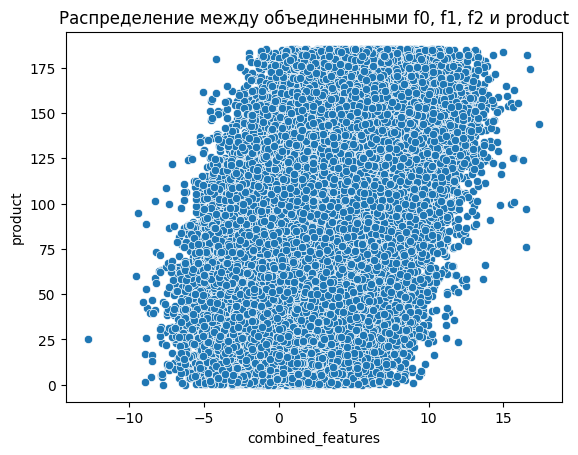

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.48
--------------------------------------------------------------------------------
Для первого региона:


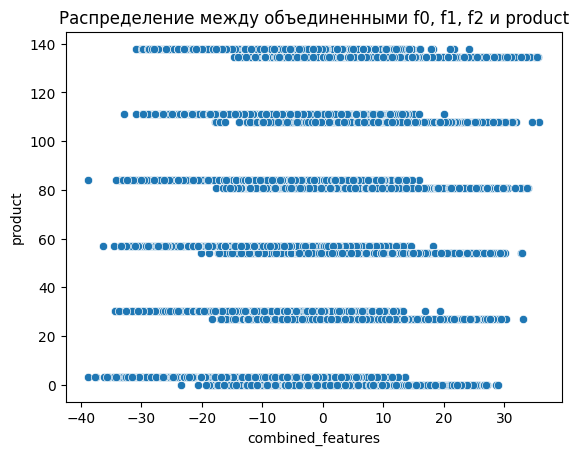

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.12
--------------------------------------------------------------------------------
Для второго региона:


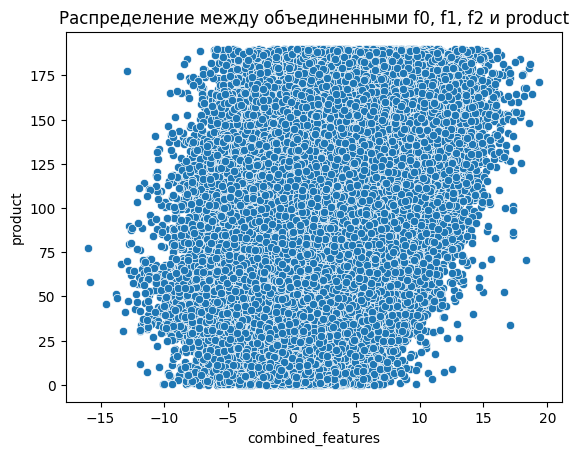

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.36


In [ ]:
print("Для нулевого региона:")
scatterplot_pearsonr(df_geo_0)
print('-' * 80)
print("Для первого региона:")
scatterplot_pearsonr(df_geo_1)
print('-' * 80)
print("Для второго региона:")
scatterplot_pearsonr(df_geo_2)


#### Вывод

На основе плотности рапределения и коэффицента Пирсона можно сделать следующие выводы:

- df_geo_0 и df_geo_2 имеют линейно зависимое распределение, так же коэффицент Пиросона находится в области рекомендуемого целевого значения, следовательно, модель будет стабильной;

- df_geo_1, данные неусточевы к линейной зависимости.

#### Наши данные имеют разные масштабы, поэтому стандартизация или нормализация данных будет полезной.

- Стандартизация обычно подразумевает вычитание среднего значения и деление на стандартное отклонение для каждого признака. Это делает данные центрированными около 0 и имеющими стандартное отклонение 1;

- Нормализация обычно подразумевает масштабирование признаков в диапазоне от 0 до 1.

Предварительная обработка данных с помощью нормализации или стандартизации важна для линейной регрессии по следующим причинам:

- Скорость сходимости: Градиентный спуск, часто используемый для оптимизации в линейной регрессии, сходится быстрее, когда признаки имеют схожий масштаб. Это потому, что градиенты по разным параметрам будут иметь схожую величину;

- Устойчивость численных методов: Многие алгоритмы оптимизации чувствительны к масштабу данных. Стандартизация или нормализация данных помогает избежать численных проблем, связанных с неустойчивостью или затуханием градиентов;

- Интерпретация коэффициентов: Стандартизированные или нормализованные данные облегчают интерпретацию коэффициентов модели. Когда все признаки имеют одинаковый масштаб, коэффициенты можно интерпретировать как важность каждого признака для прогнозируемой переменной;

- Регуляризация: Если мы используем регуляризацию (например, L1 или L2), то важно масштабировать данные, потому что регуляризация штрафует абсолютные значения коэффициентов. Если один признак имеет масштаб, значительно отличающийся от других, его коэффициент будет непропорционально штрафоваться.

#### Подготовим данные к обучению

In [ ]:
# df_geo_0
# X используем для обозначения признаков (features)
# y используем для обозначения целевой переменной (target)
X_features = df_geo_0.drop(['id', 'product'], axis = 1)
y_target = df_geo_0['product']

# Разделение данных на обучающую (75%) и временную (25%) выборки
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_features, y_target, test_size=0.25, random_state=random_state)

In [ ]:
# df_geo_1
# X используем для обозначения признаков (features)
# y используем для обозначения целевой переменной (target)
X_features = df_geo_1.drop(['id', 'product'], axis = 1)
y_target = df_geo_1['product']

# Разделение данных на обучающую (75%) и временную (25%) выборки
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_features, y_target, test_size=0.25, random_state=random_state)

In [ ]:
# df_geo_2
# X используем для обозначения признаков (features)
# y используем для обозначения целевой переменной (target)
X_features = df_geo_2.drop(['id', 'product'], axis = 1)
y_target = df_geo_2['product']

# Разделение данных на обучающую (75%) и временную (25%) выборки
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_features, y_target, test_size=0.25, random_state=random_state)

#### Вывод

Анализ показал, что данные находятся в хорошем состоянии (чистые) и подготовлены для проведения обучения, кроме Data Frame df_geo_1.

<a id="Этап_2"></a>

#### Этап 2. Обучение моделей

[Вернуться к задачам исследования](#Задачи_исследования)

#### Коэффициент Пирсона

Коэффициент корреляции Пирсона — это статистическая мера силы и направления линейной связи между двумя переменными. Коэффициент корреляции может принимать значения от -1 до +1. Значение +1 означает совершенную положительную линейную связь, значение -1 означает совершенную отрицательную линейную связь, а 0 означает отсутствие линейной связи.

Коэффициент корреляции Пирсона рассчитывается по формуле:

- $ r = \frac{n(\sum x_i y_i) - (\sum x_i)(\sum y_i)}{\sqrt{[n\sum x_i^2 - (\sum x)^2][n\sum y_i^2 - (\sum y_i)^2]}} $

где:

- $x$ и $y$ — значения переменных;

- $n$ — количество наблюдений.

Числитель:

- $ n(\sum x_i y_i) - (\sum x_i)(\sum y_i)$

Эта часть формулы представляет "ковариацию" между $x_i$ и $y_i$. Ковариация показывает, насколько переменные изменяются вместе. Если $x_i$ возрастает, когда $y_i$ возрастает, то ковариация будет положительной. Если $x_i$ уменьшается, когда $y_i$ возрастает, ковариация будет отрицательной. Если переменные не имеют явной связи, ковариация будет близка к нулю.

Знаменатель:

- $\sqrt{[n\sum x_i^2 - (\sum x)^2][n\sum y_i^2 - (\sum y_i)^2]}$

Эта часть формулы представляет собой произведение стандартных отклонений $x_i$ и $y_i$. Стандартное отклонение - это мера разброса значений переменной вокруг ее среднего значения. Знаменатель нормализует ковариацию, делая коэффициент корреляции Пирсона масштабно-инвариантным, т.е. он не зависит от масштаба измерения переменных.

Итоговый коэффициент корреляции:

Таким образом, коэффициент корреляции Пирсона представляет собой нормализованную ковариацию между двумя переменными. Это дает нам меру силы и направления линейной связи между переменными.

В контексте линейной регрессии коэффициент Пирсона может быть использован для оценки степени линейной зависимости между независимыми и зависимой переменными. Это может помочь в определении того, насколько переменные подходят для использования в модели линейной регрессии.

#### Линейная регрессия

Линейная регрессия — это статистический метод, используемый для моделирования и анализа взаимосвязей между переменными, где одна или несколько независимых переменных используются для прогнозирования значения зависимой переменной.

Модель линейной регрессии предполагает линейную зависимость между независимыми и зависимыми переменными, и она строится по следующей формуле:

- $ Y=β_0 + β_1 X_1 + β_2 X_2 +…+ β_n X_n + ϵ $

где:

- $Y$ — зависимая переменная, значение которой мы хотим предсказать;

- $X_1, X_2 ,…, X_n$ — независимые переменные, которые используются для предсказания значения Y;

- $β_0$ — это константа, которая представляет собой точку пересечения линии регрессии с осью Y, когда все независимые переменные равны нулю;

- $β_1, β_2 ,…, β_n$ — это коэффициенты регрессии, которые представляют изменение зависимой переменной $Y$ на единицу, при изменении соответствующей независимой переменной $X$, при условии, что все остальные независимые переменные остаются неизменными;

- $ϵ$ — это ошибка, которая представляет разницу между фактическим значением зависимой переменной и значением, предсказанным моделью линейной регрессии.

#### Оценка параметров

Для оценки параметров $β_0, β_1 ,…, β_n$ обычно используется метод наименьших квадратов (OLS). Этот метод минимизирует сумму квадратов ошибок (SSE), которые представляют собой разницу между фактическими и предсказанными значениями зависимой переменной.

- $ [ SSE = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2] $

где:

- $Y_i$ — фактическое значение зависимой переменной для $i$-го наблюдения;

- $\hat{Y}_i$— значение зависимой переменной, предсказанное моделью линейной регрессии для $i$-го наблюдения.

#### Подбор значений наименьших квадратов

Метод наименьших квадратов (OLS) минимизирует сумму квадратов ошибок (SSE), находя значения параметров $β_0, β_1, …, β_n$, которые минимизируют SSE. Для этого, необходимо взять производные SSE по каждому параметру, приравнять их к нулю и решить полученные уравнения. Это приведет к аналитическому решению, описанному ниже.

#### Аналитическое решение

Линейная регрессия может быть представлена через аналитическое решение. Аналитическое решение можно получить, минимизируя сумму квадратов ошибок (SSE), что приводит к системе линейных уравнений, известной как уравнения нормального состояния. Для простой линейной регрессии с одной независимой переменной аналитическое решение может быть найдено из следующих формул:

- $ β_1 = \frac{n(\sum xy) - (\sum x)(\sum y)}{n\sum x^2 - (\sum x)^2} $

- $ β_0 = \frac{\sum y - β_1\sum x}{n} $

#### Предпосылки линейной регрессии

Для того чтобы модель линейной регрессии была действительной, должны выполняться следующие предпосылки:

- Линейность: Зависимость между зависимой и независимыми переменными должна быть линейной;

- Нормальность ошибок: Ошибки должны быть нормально распределены;

- Гомоскедастичность ошибок: Дисперсия ошибок должна быть одинаковой для всех значений независимых переменных;

- Независимость ошибок: Ошибки должны быть независимыми друг от друга;

- Отсутствие мультиколлинеарности: Независимые переменные не должны быть сильно коррелированными друг с другом.

#### Почему не стоит использовать интерполиационный полином Лагранжа

Интерполиационный полином Лагранжа используется для нахождения полинома, который проходит через заданный набор точек. Однако, этот метод не подходит для задач линейной регрессии по нескольким причинам:

- Переобучение: Интерполиационный полином Лагранжа будет проходить точно через каждую точку данных, что может привести к переобучению модели. Модель будет идеально описывать обучающий набор данных, но может плохо работать на новых данных;

- Высокая степень полинома: Интерполиационный полином Лагранжа может иметь высокую степень, что делает его сложным и неустойчивым. Например, если у нас есть 10 точек данных, интерполиационный полином будет 9-й степени;

- Вычислительная сложность: Расчет коэффициентов интерполиационного полинома Лагранжа может быть вычислительно сложным для больших наборов данных.

Из-за этих причин, интерполиационный полином Лагранжа не рекомендуется для задач линейной регрессии. Вместо этого, лучше использовать метод наименьших квадратов для нахождения параметров линейной регрессии.

#### Оптимизация в Линейной Регрессии: MSE и Градиентный Спуск

Основным вопросом является: как наилучшим образом "обучить" модель?

Чтобы ответить на этот вопрос, нужно понимать, что такое "качество" модели и как его можно измерить. Один из наиболее популярных методов — это минимизация среднеквадратичного отклонения (MSE).

Тем не менее, MSE — это не просто метрика качества, это функция потерь, которую можно оптимизировать. Один из эффективных методов оптимизации — градиентный спуск.

#### Линейная Регрессия: Базовая Модель

Линейная регрессия представляет собой линейную зависимость между зависимой переменной
$y$ и независимыми переменными $X$:

 - $y = \mathbf{X}\beta + \epsilon$

где:
 - $β$ — вектор коэффициентов;
 - $ϵ$ — случайная ошибка.

#### Среднеквадратичное Отклонение (MSE)

MSE — это среднее значение квадратов разности между фактическими и прогнозируемыми значениями:

 - ${MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

где:
 - $N$ — количество наблюдений;
 - $y_i$ — фактическое значение;
 - $\hat{y}^i$ — прогнозируемое значение.

#### Градиентный Спуск

Градиентный спуск — это итеративный метод оптимизации для нахождения минимума функции. В контексте линейной регрессии, мы хотим минимизировать MSE:

 - $minimize MSE(β)$

Процесс обновления вектора $β$ в градиентном спуске:

- $\beta = \beta - \alpha \nabla \text{MSE}$

где:
 - $α$ — это скорость обучения;
 - $∇MSE$— градиент MSE.

#### Что такое Градиентный Спуск?

Для проведения градиентного спуска по функции $f(x)$, где $x$ — вектор переменных, нужно вычислить градиент этой функции. Градиент — это вектор, состоящий из частных производных функции $f$ по каждой из переменных:

 - $( \nabla f(\mathbf{x}) = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_n} \right)$

Градиент указывает направление наибольшего возрастания функции. Для минимизации функции в рамках метода градиентного спуска, мы движемся в направлении, противоположном градиенту:

 - $\mathbf{x}_{\text{new}} = \mathbf{x}_{\text{old}} - \alpha \nabla f(\mathbf{x}_{\text{old}})$

Здесь $α$ — это шаг градиентного спуска, или скорость обучения. Он контролирует, насколько далеко мы движемся в каждом шаге.

#### Почему MSE и Градиентный Спуск?

1) Вычислительная Эффективность: Градиенты легко вычислить;

2) Гладкость Функции: MSE — это гладкая функция, что упрощает оптимизацию;

3) Интерпретируемость: MSE прямо связана с качеством прогнозов.

#### Заключение

MSE и градиентный спуск совместно предоставляют мощный инструментарий для обучения линейных моделей. Оптимизация MSE через градиентный спуск является эффективным и распространенным подходом в машинном обучении.

#### Оценим результаты MSE, RMSE при разных подходах к обучению

#### Создаем дефолтную модель линейной регрессии

In [ ]:
def defolt_LinearRegression(X_train, y_train, X_val, y_val):
    """
    Обучает модель линейной регрессии на обучающих данных и оценивает её производительность на валидационных данных.

    Параметры:
    X_train (array-like): Массив с обучающими признаками.
    y_train (array-like): Массив с обучающими метками.
    X_val (array-like): Массив с валидационными признаками.
    y_val (array-like): Массив с валидационными метками.

    Возвращает:
    tuple: Кортеж с двумя значениями - средней квадратичной ошибкой (MSE) и корнем из средней квадратичной ошибки (RMSE).

    Функция создает объект линейной регрессии, обучает модель на обучающих данных, делает предсказания на валидационных данных,
    и затем вычисляет MSE и RMSE для оценки производительности модели. Результаты оценки выводятся на экран.
    """

    # создание объекта линейной регрессии
    model = LinearRegression()

    # обучение модели
    model.fit(X_train, y_train)

    # предсказание на валидационных данных
    y_pred = model.predict(X_val)

    # оценка модели
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    mse, rmse

    print('MSE:', mse)
    print('RMSE:', rmse)

In [ ]:
print("Для нулевого региона:")
defolt_LinearRegression(X_train_0, y_train_0, X_val_0, y_val_0)
print("-"*25)
print("Для первого региона:")
defolt_LinearRegression(X_train_1, y_train_1, X_val_1, y_val_1)
print("-"*25)
print("Для второго региона:")
defolt_LinearRegression(X_train_2, y_train_2, X_val_2, y_val_2)

Для нулевого региона:
MSE: 1420.7389814523888
RMSE: 37.69269135326355
-------------------------
Для первого региона:
MSE: 0.7917210878314158
RMSE: 0.8897871025315077
-------------------------
Для второго региона:
MSE: 1612.9302075047565
RMSE: 40.16130236315497


#### Выполним преобразование данных, чтобы сделать их более "нормальными" в статистическом смысле, после чего обучим модель линейной регрессии на этих данных.

PowerTransformer из библиотеки scikit-learn выполняет степенное преобразование данных, чтобы сделать их более "нормальными" в статистическом смысле. Это означает, что после преобразования распределение данных стремится к нормальному (гауссовому) распределению.

Два наиболее распространенных метода степенного преобразования, встроенных в PowerTransformer, это:

- Преобразование Йео-Джонсона (Yeo-Johnson): это преобразование может быть применено к данным, которые могут принимать как положительные, так и отрицательные значения;

- Преобразование Бокса-Кокса (Box-Cox): это преобразование может быть применено только к данным, которые принимают положительные значения.

Основная идея обоих преобразований заключается в поиске оптимального параметра $λ$ таким образом, чтобы минимизировать отклонение распределения преобразованных данных от нормального распределения.

Формула преобразования Йео-Джонсона:

- $
y' =
\begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \text{ и } y \geq 0 \\
\ln(y + 1) & \text{если } \lambda = 0 \text{ и } y \geq 0 \\
-\frac{(-y)^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \text{ и } y < 0 \\
-\ln(-y + 1) & \text{если } \lambda = 0 \text{ и } y < 0
\end{cases} $

Формула преобразования Бокса-Кокса:

- $
y' =
\begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \\
\ln(y) & \text{если } \lambda = 0
\end{cases}
\ $

Причины для использования таких преобразований:

- Нормальность: Многие статистические методы делают предположение о нормальности ошибок. Если исходные данные сильно отклоняются от нормального распределения, применение степенного преобразования может помочь;

- Гомоскедастичность: Преобразование может помочь стабилизировать дисперсию данных;

- Линейные отношения: В некоторых случаях преобразование может помочь в установлении линейных отношений между переменными.

Применяя PowerTransformer к данным, мы можете улучшить производительность многих алгоритмов машинного обучения, особенно если исходные данные имеют сильные отклонения от нормального распределения или нелинейные отношения.

In [ ]:
def PowerTransformer_LinearRegression(X_train, y_train, X_val, y_val):
    """
    Обучает модель линейной регрессии после применения Power Transformation к признакам.

    Параметры:
    X_train (array-like): Массив с обучающими признаками.
    y_train (array-like): Массив с обучающими метками.
    X_val (array-like): Массив с валидационными признаками.
    y_val (array-like): Массив с валидационными метками.

    Функция создает объект PowerTransformer, применяет его к обучающим и валидационным данным,
    затем создает объект линейной регрессии, обучает модель на преобразованных данных, делает предсказания на валидационных данных
    и затем вычисляет MSE (Mean Squared Error) и RMSE (Root Mean Squared Error) для оценки производительности модели.
    Результаты оценки выводятся на экран.
    """

    # создание объекта PowerTransformer
    pt = PowerTransformer()

    # преобразование данных
    X_train = pt.fit_transform(X_train)
    X_val = pt.transform(X_val)

    # создание объекта линейной регрессии
    model = LinearRegression()

    # обучение модели
    model.fit(X_train, y_train)

    # предсказание на валидационных данных
    y_pred = model.predict(X_val)

    # оценка модели
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    mse, rmse

    print('MSE:', mse)
    print('RMSE:', rmse)

In [ ]:
print("Для нулевого региона:")
PowerTransformer_LinearRegression(X_train_0, y_train_0, X_val_0, y_val_0)
print("-"*25)
print("Для первого региона:")
PowerTransformer_LinearRegression(X_train_1, y_train_1, X_val_1, y_val_1)
print("-"*25)
print("Для второго региона:")
PowerTransformer_LinearRegression(X_train_2, y_train_2, X_val_2, y_val_2)

Для нулевого региона:
MSE: 1420.8035593241736
RMSE: 37.69354798004791
-------------------------
Для первого региона:


MSE: 8.895371194460719
RMSE: 2.9825108875678423
-------------------------
Для второго региона:
MSE: 1586.1468737266662
RMSE: 39.82645946762863


#### Преоброзуем исходные признаки в полиномиальные признаки, после чего обучим модель линейной регрессии на этих данных.

Что такое преобразование в полиномиальные признаки?

Полиномиальное преобразование признаков заключается в создании комбинаций исходных признаков путем возведения их в степень и/или путем их перемножения между собой. Это позволяет модели улавливать нелинейные зависимости между признаками и целевой переменной.

Пример:
Предположим, у нас есть два признака $X_1$ и $X_2$. Если мы используем PolynomialFeatures с degree=2 (вторая степень), то на выходе мы получим:

- Оригинальные признаки: $X_1$ и $X_2$;

- Признаки, возведенные в квадрат: $X_1^2$ и $X_2^2$;

- Перекрестные признаки (комбинации оригинальных признаков): $X_1$ x $X_2$

- Таким образом, преобразованный набор данных будет содержать следующие признаки: $X_1$ и $X_2$, $X_1^2$ и $X_2^2$, $X_1$ x $X_2$.

Зачем это нужно?

- Поиск нелинейных зависимостей: Линейные модели, как известно, могут моделировать только линейные зависимости. При добавлении полиномиальных признаков линейная модель может стать способной улавливать нелинейные зависимости в данных;

- Улучшение производительности: Для некоторых наборов данных добавление полиномиальных признаков может значительно улучшить качество модели;

- Интерпретируемость: Полиномиальные признаки могут помочь в интерпретации зависимостей в данных, особенно если есть основания полагать, что между признаками и целевой переменной существует нелинейная связь.

На что стоит обратить внимание:

- Размерность данных: Преобразование в полиномиальные признаки быстро увеличивает количество признаков. Например, если у вас 10 признаков и вы используете degree=3, количество признаков может значительно увеличиться. Это может привести к проблемам с производительностью и риском переобучения;

- Переобучение: Добавление слишком многих полиномиальных признаков может привести к переобучению модели. Важно всегда проверять качество модели на отложенной выборке или использовать кросс-валидацию;

- Масштабирование: Полиномиальные признаки могут иметь очень разные масштабы по сравнению с исходными данными. Часто полезно применить масштабирование признаков после создания полиномиальных признаков, особенно если вы используете алгоритмы, чувствительные к масштабу признаков (например, градиентный спуск).

В целом, полиномиальное преобразование признаков - это мощный инструмент для улучшения линейных моделей, но его следует использовать с осторожностью, учитывая возможные побочные эффекты.

In [ ]:
def PolynomialFeatures_LinearRegression(X_train, y_train, X_val, y_val):
    """
    Обучает модель линейной регрессии после применения полиномиальных признаков и масштабирования.

    Параметры:
    X_train (array-like): Массив с обучающими признаками.
    y_train (array-like): Массив с обучающими метками.
    X_val (array-like): Массив с валидационными признаками.
    y_val (array-like): Массив с валидационными метками.

    Функция создает объект PolynomialFeatures с заданной степенью полинома, применяет его к обучающим и валидационным данным,
    затем масштабирует признаки с помощью StandardScaler, создает объект линейной регрессии, обучает модель на преобразованных данных,
    делает предсказания на валидационных данных и затем вычисляет MSE (Mean Squared Error) и RMSE (Root Mean Squared Error)
    для оценки производительности модели. Результаты оценки выводятся на экран.
    """

    # Создание объекта PolynomialFeatures
    poly = PolynomialFeatures(degree=2)

    # Преобразование данных
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Масштабирование признаков после преобразования
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)

    # Создание объекта линейной регрессии
    model = LinearRegression()

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Предсказание на валидационных данных
    y_pred = model.predict(X_val_scaled)

    # Оценка модели
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    print('MSE:', mse)
    print('RMSE:', rmse)

In [ ]:
print("Для нулевого региона:")
PolynomialFeatures_LinearRegression(X_train_0, y_train_0, X_val_0, y_val_0)
print("-"*25)
print("Для первого региона:")
PolynomialFeatures_LinearRegression(X_train_1, y_train_1, X_val_1, y_val_1)
print("-"*25)
print("Для второго региона:")
PolynomialFeatures_LinearRegression(X_train_2, y_train_2, X_val_2, y_val_2)

Для нулевого региона:
MSE: 1421.113066257243
RMSE: 37.69765332560162
-------------------------
Для первого региона:
MSE: 0.79168905873919
RMSE: 0.8897691041720824
-------------------------
Для второго региона:


MSE: 1512.5385550407377
RMSE: 38.89136864447866


#### Произведем поиск по сетке (Grid Search) с конвейером (Pipeline) и найдем наилучшие гиперпараметры, после чего обучим модель линейной регрессии на этих данных.



In [ ]:
def Linear_Regression(X_train, y_train):
    """
    Обучает линейную регрессионную модель с оптимизированными гиперпараметрами.

    Параметры:
    X_train (array-like): Массив с обучающими признаками.
    y_train (array-like): Массив с обучающими метками.

    Возвращает:
    best_model (object): Лучшая обученная модель линейной регрессии с оптимальными гиперпараметрами.

    Функция создает конвейер (Pipeline) с последовательными этапами обработки данных и обучения модели:
    1. Преобразование признаков с использованием PowerTransformer.
    2. Масштабирование признаков с использованием MinMaxScaler.
    3. Создание полиномиальных признаков.
    4. Обучение линейной регрессионной модели.

    Далее, функция использует GridSearchCV для перебора различных комбинаций гиперпараметров:
    - transformer: Различные методы преобразования признаков или их отсутствие.
    - scaler: Различные методы масштабирования признаков или их отсутствие.
    - poly__degree: Разные степени полиномиальных признаков.

    Лучшая модель выбирается на основе наименьшего значения корня из средней квадратичной ошибки (RMSE).

    В конце функции, лучшая модель возвращается в качестве результата.

    # Создаем конвейер с несколькими шагами:
    # 1. transformer: PowerTransformer для преобразования признаков к гауссовому распределению.
    # 2. scaler: Масштабирование признаков.
    # 3. poly: Создание полиномиальных признаков.
    # 4. model: Линейная регрессия как предсказательная модель.
    """

    pipe = Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures()),
        ('model', LinearRegression())
    ])

    # Словарь параметров для перебора в GridSearchCV.
    # - transformer: используем разные методы или не используем вовсе.
    # - scaler: разные методы масштабирования или не используем.
    # - poly__degree: разные степени полиномиальных признаков.
    param_grid = {
        'transformer': [None, PowerTransformer(method='yeo-johnson'), PowerTransformer(method='box-cox')],
        'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
        'poly__degree': [1, 2, 3],
    }

    # Создаем объект GridSearchCV для автоматического перебора параметров и кросс-валидации.
    # cv=3 означает, что будет использоваться 3-кратная кросс-валидация.
    # scoring указывает на то, что качество моделей будет оцениваться по neg_mean_squared_error.
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)

    # Сохраняем лучшие параметры и результат лучшей модели.
    best_params = grid.best_params_
    best_score = np.sqrt(-grid.best_score_)  # Возьмем корень из MSE для получения RMSE.

    print(best_params, best_score)

    # Предсказание с помощью лучшей модели.
    y_pred = grid.predict(X_train)

    # Вычисляем ошибки модели: MSE и RMSE.
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)

    print('MSE:', mse)
    print('RMSE:', rmse)

    # Сохраняем лучшую модель в переменную best_model.
    best_model = grid.best_estimator_

    return best_model

In [ ]:
print("Для нулевого региона:")
best_model_0 = Linear_Regression(X_train_0, y_train_0)
print("-"*25)
print("Для первого региона:")
best_model_1 = Linear_Regression(X_train_1, y_train_1)
print("-"*25)
print("Для второго региона:")
best_model_2 = Linear_Regression(X_train_2, y_train_2)

Для нулевого региона:


{'poly__degree': 3, 'scaler': StandardScaler(), 'transformer': PowerTransformer()} 37.18407366033365
MSE: 1381.1095763075423
RMSE: 37.163282636327246
-------------------------
Для первого региона:
{'poly__degree': 3, 'scaler': MinMaxScaler(), 'transformer': PowerTransformer()} 0.7318052089486733
MSE: 0.5348269363257092
RMSE: 0.7313186284552782
-------------------------
Для второго региона:
{'poly__degree': 3, 'scaler': MinMaxScaler(), 'transformer': PowerTransformer()} 38.396673338462975
MSE: 1473.4021646711885
RMSE: 38.38492105855095


#### Вывод

Модель линейной регрессии обученная через поиск по сетке (Grid Search) с конвейером (Pipeline) показала наилучшие результаты MSE и RMSE в отличие от дефолтного обучения или точечного подхода в поисках трансформеров и маштабирования.

<a id="Этап_3"></a>

#### Этап 3: Подготовка к расчету прибыли

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
BUDGET = 10e9                    # бюджет на разработку скважин в рублях
BARREL_REVENUE = 450             # доход с одного барреля в рублях
UNIT_REVENUE = 450e3             # доход с одной единицы продукта (тыс. баррелей) в рублях
NUM_WELLS_FOR_DEVELOPMENT = 200  # количество скважин, выбранных для разработки
NUM_WELLS_FOR_EXPLORATION = 500  # количество скважин для исследования при разведке региона

<a id="3.1"></a>

#### 3.1. Рассчет достаточного объема сырья для безубыточной разработки новой скважины

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
# Рассчет дохода и объема сырья, необходимого для безубыточной разработки одной скважины
profit_per_well = BUDGET / NUM_WELLS_FOR_DEVELOPMENT
required_volume_per_well = profit_per_well / UNIT_REVENUE
rounded_required_volume = math.ceil(required_volume_per_well)

print(f"Достаточный объем сырья для безубыточной разработки одной скважины: {rounded_required_volume} тыс. баррелей")

Достаточный объем сырья для безубыточной разработки одной скважины: 112 тыс. баррелей


<a id="3.2"></a>

#### 3.2 Сравниваем полученный объем сырья со средним запасом в каждом регионе

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
# Рассчитываем средние запасы для каждого региона
average_volume = [
    df_geo_0['product'].mean(),
    df_geo_1['product'].mean(),
    df_geo_2['product'].mean()
]

# Сравниваем полученный объем сырья со средним запасом в каждом регионе
for i, vol in enumerate(average_volume, 1):
    print(f"Средний запас в регионе {i - 1}: {vol:.2f} тыс. баррелей. Разница со средним объемом: {vol - required_volume_per_well:.2f} тыс. баррелей")

Средний запас в регионе 0: 92.50 тыс. баррелей. Разница со средним объемом: -18.61 тыс. баррелей
Средний запас в регионе 1: 68.83 тыс. баррелей. Разница со средним объемом: -42.29 тыс. баррелей
Средний запас в регионе 2: 95.00 тыс. баррелей. Разница со средним объемом: -16.11 тыс. баррелей


<a id="Этап_4"></a>

#### Этап 4: Функция для расчета прибыли

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
def profit(y_true, y_pred):
    """
    Вычисляет ожидаемую прибыль на основе истинных и предсказанных значений запасов сырья.

    Функция выбирает скважины с максимальными предсказанными значениями запасов сырья. Затем
    суммирует истинные значения запасов сырья для выбранных скважин и вычисляет прибыль на
    основе суммарного объема сырья, учитывая стоимость одной единицы сырья и общий бюджет на разработку скважин.

    Параметры:
    - y_true (pd.Series): Истинные значения запасов сырья для каждой скважины.
    - y_pred (np.array): Предсказанные значения запасов сырья для каждой скважины.

    Возвращает:
    - float: Ожидаемая прибыль на основе истинных и предсказанных значений запасов сырья.
    """
    selected = y_true.iloc[y_pred.argsort()[-NUM_WELLS_FOR_DEVELOPMENT:]]
    total_volume = selected.sum()
    return total_volume * UNIT_REVENUE - BUDGET

<a id="Задачи_исследования"></a>

#### Этап 5: Риски и прибыль

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
def bootstrap(y_true, y_pred, n_iterations=1000):
    """
    Оценка прибыли с использованием метода бутстрэп.

    Функция применяет метод бутстрэп для оценки распределения ожидаемой прибыли на основе
    истинных и предсказанных значений запасов сырья для скважин. Для каждой итерации метода бутстрэп
    создается подвыборка из истинных значений запасов сырья, затем рассчитывается прибыль
    с использованием соответствующих предсказанных значений.

    Параметры:
    - y_true (pd.Series): Истинные значения запасов сырья для каждой скважины.
    - y_pred (np.array): Предсказанные значения запасов сырья для каждой скважины.
    - n_iterations (int, опционально): Количество итераций бутстрэп. По умолчанию 1000.

    Возвращает:
    - list: Список прибыли для каждой итерации бутстрэп.
    """
    profits = []
    for _ in range(n_iterations):
        random_state = np.random.RandomState()
        subsample = y_true.sample(NUM_WELLS_FOR_EXPLORATION, replace=True, random_state=random_state)  # выбираем 500 точек для исследования
        y_subsample_pred = y_pred[subsample.index]
        profits.append(profit(subsample, y_subsample_pred))
    return profits

In [ ]:
# Применение бутстрэпа для каждого региона
best_models = [best_model_0, best_model_1, best_model_2]
dfs = [df_geo_0, df_geo_1, df_geo_2]

for i, (best_model, df) in enumerate(zip(best_models, dfs), 1):
    y_true = df['product']
    y_pred = best_model.predict(df.drop(['id', 'product'], axis=1))
    profits = bootstrap(y_true, y_pred)

    average_profit = np.mean(profits)
    confidence_interval = (np.percentile(profits, 2.5), np.percentile(profits, 97.5))
    loss_risk = sum([1 for p in profits if p < 0]) / len(profits)

    print(f"Регион {i}:")
    print(f"Средняя прибыль: {average_profit:.2f} руб.")
    print(f"95% доверительный интервал: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
    print(f"Риск убытков: {loss_risk * 100:.2f}%")
    print("-" * 50)

Регион 1:
Средняя прибыль: 500425097.22 руб.
95% доверительный интервал: (-2631463.56, 1022899907.63)
Риск убытков: 2.80%
--------------------------------------------------
Регион 2:
Средняя прибыль: 442205020.91 руб.
95% доверительный интервал: (34602672.30, 852360983.67)
Риск убытков: 1.60%
--------------------------------------------------
Регион 3:
Средняя прибыль: 615556155.67 руб.
95% доверительный интервал: (85876289.81, 1138505977.73)
Риск убытков: 1.60%
--------------------------------------------------


#### Вывод

На основе оценки рисков и предсказаний модели линейной регрессии можно сделать следующий вывод: регион 3 является наилучшим местом для добычи нефти, так как риск убытков состовляется менее 2.5%, а средня прибыть больше чем в остальных регионах.